# Code for KDDM2 exercise - time series forecasting

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels
import seaborn as sns

# Loading the data

Any data-based process must begin by acquiring and loading the data, so we start with this.

We note that it comes in a CSV file and has a "?" for missing values. We use memory-mapping to speed
up the parsing, as the file is large.

In [2]:
df = pd.read_csv('household_power_consumption.txt', sep=';', na_values=['?', 'nan'],
                 parse_dates={'Date_Time': ['Date', 'Time']}, infer_datetime_format=True,
                 memory_map=True, index_col='Date_Time')

# Looking at the data

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2075259 entries, 2006-12-16 17:24:00 to 2010-11-26 21:02:00
Data columns (total 7 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Global_active_power    float64
 1   Global_reactive_power  float64
 2   Voltage                float64
 3   Global_intensity       float64
 4   Sub_metering_1         float64
 5   Sub_metering_2         float64
 6   Sub_metering_3         float64
dtypes: float64(7)
memory usage: 126.7 MB


In [4]:
df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
Date_Time,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [5]:
df.shape

(2075259, 7)

In [6]:
df.describe()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
count,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06
mean,1.091615e+00,1.237145e-01,2.408399e+02,4.627759e+00,1.121923e+00,1.298520e+00,6.458447e+00
std,1.057294e+00,1.127220e-01,3.239987e+00,4.444396e+00,6.153031e+00,5.822026e+00,8.437154e+00
min,7.600000e-02,0.000000e+00,2.232000e+02,2.000000e-01,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.080000e-01,4.800000e-02,2.389900e+02,1.400000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,6.020000e-01,1.000000e-01,2.410100e+02,2.600000e+00,0.000000e+00,0.000000e+00,1.000000e+00
75%,1.528000e+00,1.940000e-01,2.428900e+02,6.400000e+00,0.000000e+00,1.000000e+00,1.700000e+01
max,1.112200e+01,1.390000e+00,2.541500e+02,4.840000e+01,8.800000e+01,8.000000e+01,3.100000e+01


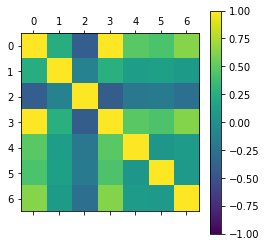

In [7]:
plt.matshow(df.corr(method='pearson'),vmax=1,vmin=-1)
plt.colorbar()
plt.show()

We see 7 columns, and a date-time index.

Of course, it is useful to know what the columns represent, so researched this. The dataset contains various measurements
of physical quantities relating to the power consumption of a household.

* *Global_active_power*:
    Measures "useful" power. The details about this are related to AC power transmission and are not that important.
* *Global_reactive_power*:
    Measures "useless" power. Can be combined as a complex number with the active power to obtain the apparent power as a
    magnitude. We will not be doing any physically-based modelling here however, as this is not the scope of this course.
* *Voltage*:
    Minute averaged voltage.
* *Global_intensity*:
    Minute averaged current intensity
* *Sub_metering_1, Sub_metering_2, Sub_metering_3*:
    Active energy of the kitchen, laundry room and climate control systems
    
Note that the active power and the current are highly correlated. This is because voltage will be a pretty
constant 240 V, and $P = UI$. So, current is roughly proportional to power and voltage is not that interesting of  a variable. Reactive power and power should also be related, but in a less straightforward way.

We also note that this is *a lot* of data, as we have a sampling frequency of 1 minute over several years, making
for 2075259 data points.

# Goals and methods

In summary, we have a multivariate time series consisting of 7 variables. Our goal in this assignment is time-series prediction; in particular, I choose to predict the global active power of the whole household, given the last $n$ (to be determined) values of this metric. The other values should all be highly correlated to this value anyway (except for the sub-meterings, which could be an interesting multivariate prediction problem), so I will not focus too much on modelling them or using them for the predictions.

I also chose to work with *daily* power data, as this makes it a bit easier to work with the data.

# Dealing with missing data points

As we have discovered when trying to load the CSV file, we have some missing data. First, we will need to find out how much.

In [8]:
num_rows_with_null = np.sum(df.isnull().any(axis=1))
num_rows_with_null

25979

In [9]:
np.sum(df.isnull())

Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64

In [10]:
fraction_null = num_rows_with_null / df.shape[0]
fraction_null

0.012518437457686004

In [11]:
 df.shape[0]

2075259

This means about 1.2% of all data points are missing. And when datapoints are missing, the whole row is missing, not just single values in the column. We can deal with this through imputation or dropping the affected rows.

For imputation, we suggest using linear interpolation. Using a column-wide statistic would not be good, because it would introduce
spurious discontinuities.

In [12]:
df = df.interpolate()

In [13]:
num_rows_with_null = np.sum(df.isnull().any(axis=1))
num_rows_with_null

0

# Plotting the time series

To plot the series and see structures on different scales, I will resample the series on different sampling intervals: Hourly, daily, monthly and yearly consumption.

In [14]:
sns.set(rc={'figure.figsize':(11, 4)})

In [15]:
df_hourly = df['Global_active_power'].resample('H').sum()
df_daily = df['Global_active_power'].resample('D').sum()
df_monthly = df['Global_active_power'].resample('M').sum()
df_yearly = df['Global_active_power'].resample('Y').sum()

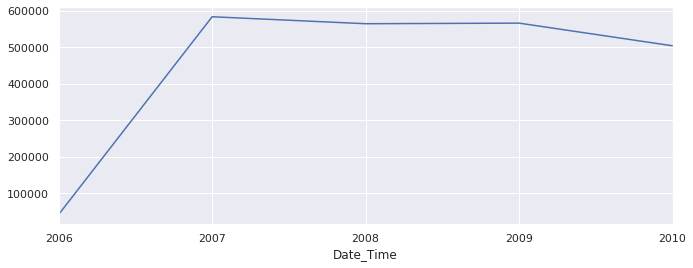

In [16]:
df_yearly.plot()

On the yearly scale, we can see a trend in the beginning and then a pretty constant, decreasing baseline.

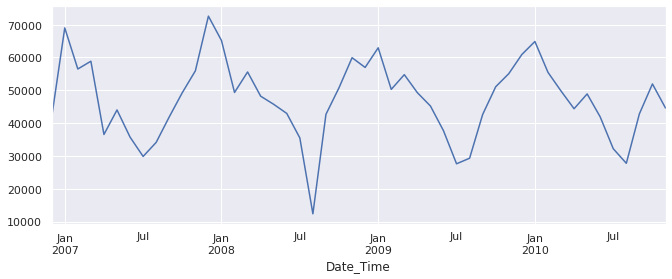

In [17]:
df_monthly.plot()
plt.savefig('monthly.png')

On the monthly scale, we can see some pretty clear seasonality associated with the summer months. 

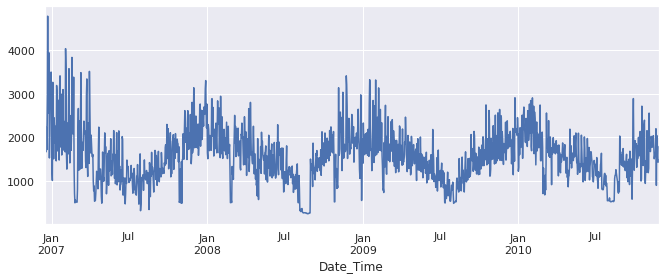

In [18]:
df_daily.plot()
plt.savefig("daily_plot")

We can see some events which will make prediction harder, like a vacation that was presumably taken in the August-Septembre period here.

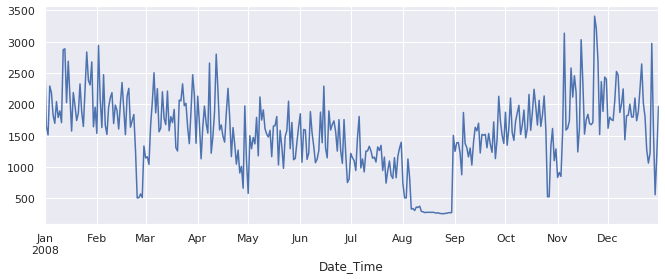

In [19]:
df_daily['2008'].plot()
plt.savefig('monthly_plot')

We see some evidence of weekly seasonality (weekends, workdays) and random events causing low consumption, like
at the end of October.

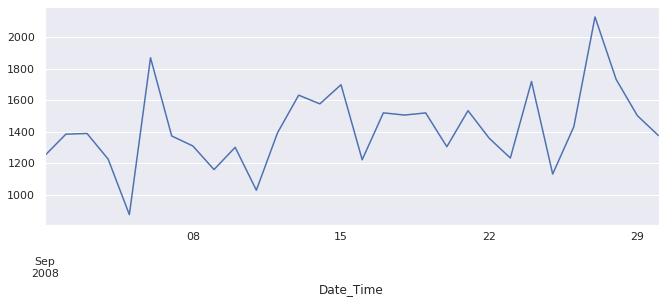

In [20]:
df_daily['2008-9'].plot()
plt.savefig('plot_days')

Hourly seasonality is to be expected, as people sleep during the night and use little power. We can see this here.

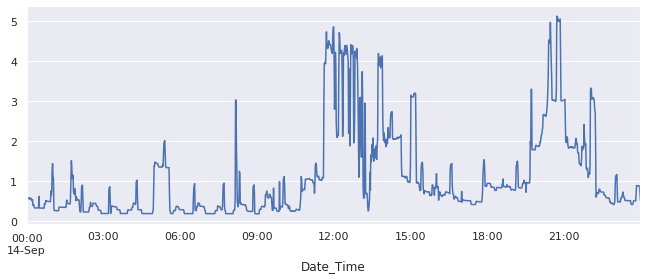

In [21]:
df['Global_active_power']['2008-9-14'].plot()
plt.savefig('plot_hours')

Interestingly, here, we see some seasonality on even a very fine scale. I suspect that this is due to way some electric devices work or due to the measuring process.

# Predicting future power consumption

When predicting the future power consumption, we have to ask a few questions:

* What model? Standard models for TS prediction are ARIMA, SARIMAX and VAR. Also available are RNN-based models. Simpler models may be easier to interpret and suffer less from overfitting, but RNNs would be an option too, as we have a lot of data.
* What scale? Hourly, monthly, daily, yearly? That will probably depend on the application. Some automated power regulation circuitry might want fine-grained, hourly or even finer predictions, while a customer wanting to optimize his power usage might prefer daily-monthly. 

First, what can we say about the data? It has complex, multi-leveled seasonality, undpredictable noise events like vacations and trips and shifting large-scale trends. For any ARIMA model, we would also have to ask if these things are multiplicative or additive. The best approach will probably be to try different methods and compare their predictive power. 

## Defining a supervised forecasting problem

For some approaches, it helps to reorganize the data such that we get a supervised learning task.
This is used for the baseline model. We also define the training and test datasets here.

In [22]:
forecasting_dataset = pd.concat([df_daily.shift(1), df_daily], axis=1)
forecasting_dataset.columns = ['t-1', 't']
forecasting_dataset.head()

,t-1,t
Date_Time,,
2006-12-16,NaN,1209.176
2006-12-17,1209.176,3390.460
2006-12-18,3390.460,2203.826
2006-12-19,2203.826,1666.194
2006-12-20,1666.194,2225.748


## Train-test split

In [23]:
X = forecasting_dataset
train_size = int(len(X) * 0.8)
train, test = X[1:train_size], X[train_size:]
train_X, train_y = train["t-1"], train["t"]
test_X, test_y = test["t-1"], test["t"]

In [24]:
train_X.head()

Date_Time
2006-12-17    1209.176
2006-12-18    3390.460
2006-12-19    2203.826
2006-12-20    1666.194
2006-12-21    2225.748
Freq: D, Name: t-1, dtype: float64

In [25]:
train_y.head()

Date_Time
2006-12-17    3390.460
2006-12-18    2203.826
2006-12-19    1666.194
2006-12-20    2225.748
2006-12-21    1717.114
Freq: D, Name: t, dtype: float64

## Baseline model

In [26]:
def evaluate_test_forecasting_rmse(X_test, y_test, model):
    predictions = []
    for x in X_test:
        y_pred = model(x)
        predictions.append(y_pred)
    predictions = np.array(predictions)
    return np.sqrt(np.mean((predictions - y_test) ** 2))

In [27]:
evaluate_test_forecasting_rmse(test_X.values, test_y.values, lambda x : x)

411.92154862254097

The simplest possible baseline prediction model (just repeat the value) has a baseline RMSE of about 412.

## ARIMA

In [28]:
import statsmodels.tsa as tsa
import statsmodels.tsa.seasonal

Seasonal decomposition

In [29]:
decomp_daily = tsa.seasonal.seasonal_decompose(train_X, model='mult', period=360, extrapolate_trend=1)

In [30]:
decomp_daily_full = tsa.seasonal.seasonal_decompose(df_daily, model='mult', period=360, extrapolate_trend=1)

In [31]:
df_decomp = pd.DataFrame({'Value': train_X, 'Trend': decomp_daily.trend, 'Seasonality': decomp_daily.seasonal, 'Residuals': decomp_daily.resid})

In [32]:
decomp_full = pd.DataFrame({'Value': df_daily, 'Trend': decomp_daily_full.trend, 'Seasonality': decomp_daily_full.seasonal, 'Residuals': decomp_daily_full.resid})

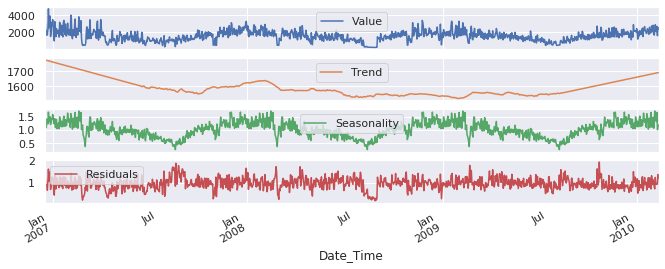

In [34]:
df_decomp.plot(subplots=True)
plt.savefig("decomp-plot")

We can use the augmented Dickley-Fuller test to check if the residuals are stationary

In [39]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(df_decomp["Residuals"])
result

(-5.6539399635742935,
 9.717523904149968e-07,
 22,
 1129,
 {'1%': -3.436155341313321,
  '5%': -2.8641034026875123,
  '10%': -2.568134825546958},
 -226.1856168414506)

The second value is the $p$-value. It is below 5%, thus the test suggests stationarity

In [35]:
seasonally_adjusted_daily = (train_X / decomp_daily.seasonal) / decomp_daily.trend

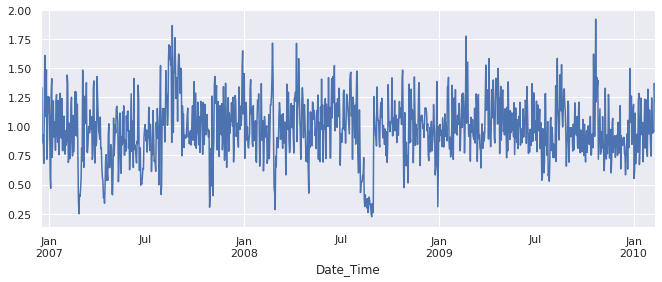

In [36]:
seasonally_adjusted_daily.plot()

## PACF/ACF

In [37]:
import statsmodels.graphics.tsaplots

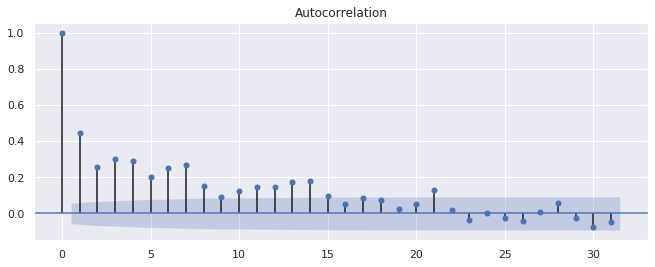

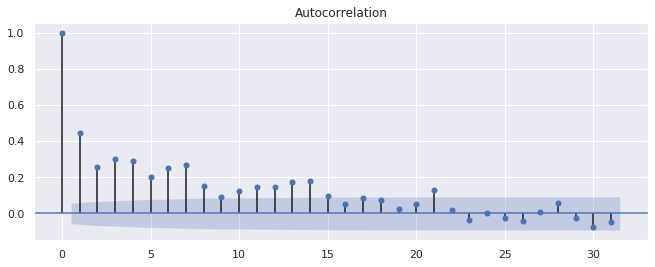

In [38]:
statsmodels.graphics.tsaplots.plot_acf(seasonally_adjusted_daily)

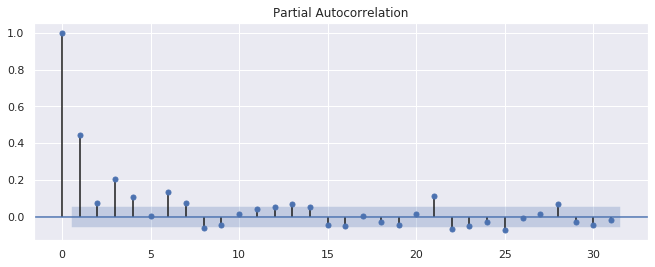

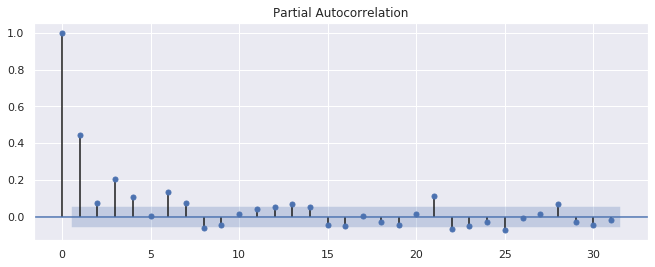

In [39]:
statsmodels.graphics.tsaplots.plot_pacf(seasonally_adjusted_daily)

For finding optimal ARIMA parameters, I will use the pyramid-arima package, which mimics similar functionality from R.

In [ ]:
from pmdarima.arima import auto_arima

In [43]:
results = auto_arima(seasonally_adjusted_daily)

In [48]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1152
Model:               SARIMAX(3, 0, 1)   Log Likelihood               -8408.129
Date:                Thu, 28 Jan 2021   AIC                          16826.257
Time:                        02:43:32   BIC                          16851.504
Sample:                             0   HQIC                         16835.787
                               - 1152                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9684      0.078     12.393      0.000       0.815       1.122
ar.L2         -0.2457      0.046     -5.311      0.000      -0.336      -0.155
ar.L3          0.1572      0.034      4.574      0.000       0.090       0.225
ma.L1         -0.6082      0.076     -8.008      0.000      -0.757      -0.459
sigma2      1.294e+05   5095.359     25.387      0.000    1.19e+05    1.39e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                17.46
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               0.67   Skew:                             0.21
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.43
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [41]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA

In [42]:
model = ARIMA(seasonally_adjusted_daily, 
 order=(3,0,1),
)

In [43]:
results = model.fit()

In [44]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1152
Model:                 ARIMA(3, 0, 1)   Log Likelihood                  91.301
Date:                Fri, 29 Jan 2021   AIC                           -170.603
Time:                        01:14:10   BIC                           -140.307
Sample:                    12-17-2006   HQIC                          -159.168
                         - 02-10-2010                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9819      0.022     45.028      0.000       0.939       1.025
ar.L1          0.9816      0.077     12.824      0.000       0.832       1.132
ar.L2         -0.2469      0.046     -5.334      0.000      -0.338      -0.156
ar.L3          0.1509      0.034      4.437      0.000       0.084       0.218
ma.L1         -0.6211      0.074     -8.372      0.000      -0.766      -0.476
sigma2         0.0499      0.002     25.394      0.000       0.046       0.054
===================================================================================
Ljung-Box (Q):                      119.47   Jarque-Bera (JB):                15.67
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.72   Skew:                             0.21
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.38
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [45]:
predictions = results.predict()

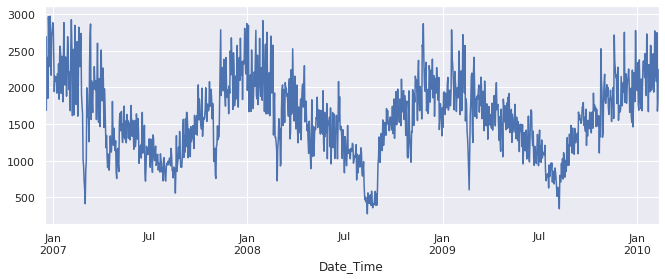

In [46]:
predicted_daily = (predictions * decomp_daily.trend) * decomp_daily.seasonal
predicted_daily.plot()

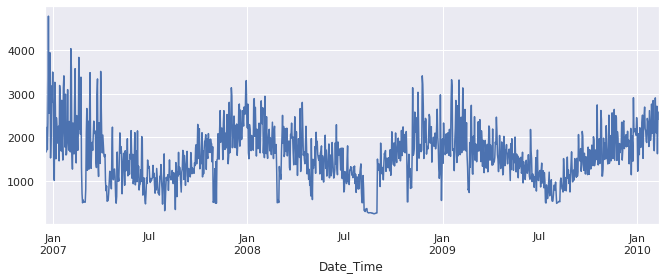

In [47]:
train_X.plot()

In [57]:
from statsmodels.tools.eval_measures import rmse
error = rmse(predicted_daily, train_X)
error

374.8225865913027

In [58]:
test_pred = results.forecast(len(test_X)) * decomp_daily_full.trend[len(train_X):]  * decomp_daily_full.seasonal[len(train_X):]

In [59]:
test_pred_error_bars = results.get_forecast(len(test_X))
frame = test_pred_error_bars.summary_frame()
ci_upper = test_pred + 2 * frame.mean_se
ci_lower = test_pred - 2 * frame.mean_se

In [67]:
test_np = test_pred.to_numpy()
ci_upper_np = ci_upper.to_numpy()
ci_lower_np = ci_lower.to_numpy()

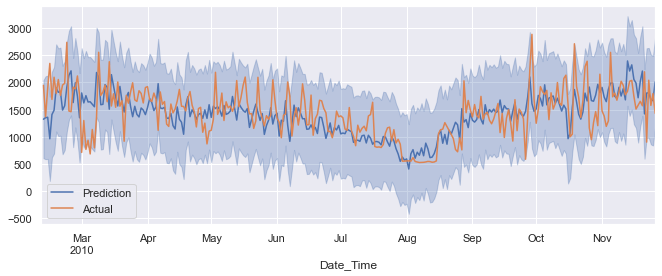

In [73]:
test_pred.plot(label="Prediction")
test_X.plot(label="Actual")
plt.fill_between(test_pred.index, ci_lower_np, ci_upper_np, color='b', alpha=.3)
plt.legend()
plt.savefig("arima-plot")

<AxesSubplot:xlabel='Date_Time'>

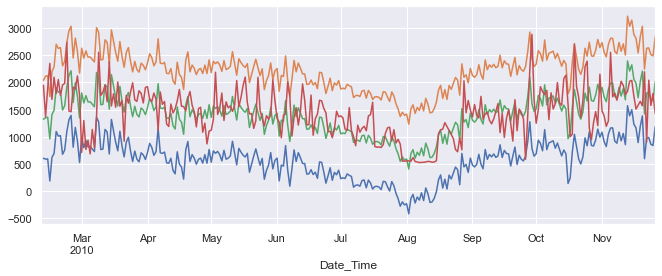

In [60]:
ci_lower.plot()
ci_upper.plot()
test_pred.plot()
test_X.plot(label="test_X")

In [61]:
len(test_pred)

290

In [105]:
error = rmse(test_pred[1:], test_X)
error

385.7375538386255

## Prophet (Facebook)

In [31]:
from fbprophet import Prophet
from statsmodels.tools.eval_measures import rmse

Importing plotly failed. Interactive plots will not work.


In [32]:
train_X

Date_Time
2006-12-17    1209.176
2006-12-18    3390.460
2006-12-19    2203.826
2006-12-20    1666.194
2006-12-21    2225.748
                ...   
2010-02-06    2098.892
2010-02-07    2712.986
2010-02-08    1625.708
2010-02-09    2582.238
2010-02-10    2420.932
Freq: D, Name: t-1, Length: 1152, dtype: float64

In [33]:
prophet_df = pd.DataFrame(train_X).reset_index()
prophet_df = prophet_df.rename(columns={"Date_Time" : "ds", "t-1" : "y"})
prophet_df

,ds,y
0,2006-12-17,1209.176
1,2006-12-18,3390.460
2,2006-12-19,2203.826
3,2006-12-20,1666.194
4,2006-12-21,2225.748
...,...,...
1147,2010-02-06,2098.892
1148,2010-02-07,2712.986
1149,2010-02-08,1625.708
1150,2010-02-09,2582.238


In [34]:
m = Prophet()
m.fit(prophet_df)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


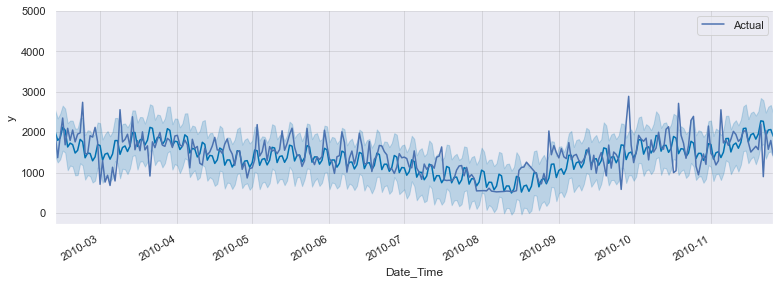

In [55]:
import datetime
fig, ax = plt.subplots()
future = m.make_future_dataframe(periods=len(test_X))
forecast = m.predict(future)
m.plot(forecast[len(train_X):], ax=ax)
test_X.plot(label="Actual")
ax.set_xlim([datetime.date(2010, 2, 11), datetime.date(2010, 11, 26)])
plt.legend()
plt.savefig("prophet-plot")

In [37]:
rmse(forecast.yhat[len(train_X):], test_X)

377.58904577576294

In [39]:
forecast[len(train_X):]

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
1152,2010-02-11,1532.776518,1455.548255,2555.453666,1532.776518,1532.776518,475.614049,475.614049,475.614049,-11.612604,-11.612604,-11.612604,487.226653,487.226653,487.226653,0.0,0.0,0.0,2008.390567
1153,2010-02-12,1532.737428,1249.096917,2372.182305,1532.737428,1532.737428,266.495163,266.495163,266.495163,-178.608370,-178.608370,-178.608370,445.103534,445.103534,445.103534,0.0,0.0,0.0,1799.232591
1154,2010-02-13,1532.698337,1326.395643,2376.081043,1532.698337,1532.698337,328.037035,328.037035,328.037035,-72.917766,-72.917766,-72.917766,400.954801,400.954801,400.954801,0.0,0.0,0.0,1860.735372
1155,2010-02-14,1532.659247,1545.559700,2666.428565,1532.659247,1532.659247,590.796699,590.796699,590.796699,235.365194,235.365194,235.365194,355.431505,355.431505,355.431505,0.0,0.0,0.0,2123.455945
1156,2010-02-15,1532.620156,1489.542996,2600.542500,1532.620156,1532.620156,517.785274,517.785274,517.785274,208.568224,208.568224,208.568224,309.217050,309.217050,309.217050,0.0,0.0,0.0,2050.405430
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1436,2010-11-22,1521.674809,1718.391879,2847.709138,1519.623324,1523.967579,747.254083,747.254083,747.254083,208.568224,208.568224,208.568224,538.685858,538.685858,538.685858,0.0,0.0,0.0,2268.928892
1437,2010-11-23,1521.635719,1339.518859,2449.771187,1519.572201,1523.943719,387.944930,387.944930,387.944930,-160.448281,-160.448281,-160.448281,548.393212,548.393212,548.393212,0.0,0.0,0.0,1909.580649
1438,2010-11-24,1521.596628,1536.776732,2618.094117,1519.519338,1523.914527,533.911592,533.911592,533.911592,-20.346396,-20.346396,-20.346396,554.257989,554.257989,554.257989,0.0,0.0,0.0,2055.508220
1439,2010-11-25,1521.557538,1523.317147,2619.495545,1519.474020,1523.887605,544.824417,544.824417,544.824417,-11.612604,-11.612604,-11.612604,556.437022,556.437022,556.437022,0.0,0.0,0.0,2066.381955


## LSTM-based RNN model

In [29]:
import tensorflow as tf
import tensorflow.keras as keras

In [30]:
n_steps = 10
n_features = 1

model = keras.models.Sequential([
    keras.layers.Bidirectional(keras.layers.LSTM(50, activation='relu', return_sequences=True), input_shape=(n_steps, n_features)),
    keras.layers.Bidirectional(keras.layers.LSTM(50, activation='relu')),
    keras.layers.Dense(1)
])

In [31]:
def create_ts_prediction_problem(X, n_steps):
    X_new = []
    y_new = []
    for i in range(n_steps, len(X) - 1):
        subseq = X[i - n_steps + 1 : i + 1]
        X_new.append(subseq)
        y_new.append(X[i + 1])
    return np.array(X_new), np.array(y_new)

In [32]:
X_train, y_train = create_ts_prediction_problem(train_X.values, n_steps)

In [33]:
X_train = X_train.reshape(len(train_X) - n_steps - 1, n_steps, n_features)
X_train.shape

(1141, 10, 1)

In [34]:
y_train

array([1528.76 , 2072.638, 3174.392, ..., 1625.708, 2582.238, 2420.932])

In [35]:
model.compile(loss="huber", optimizer="adam")

In [36]:
es = keras.callbacks.EarlyStopping(patience=15, restore_best_weights=True)
model.fit(X_train, y_train, epochs=50, validation_split=0.2, callbacks=[es])

Epoch 1/50
29/29 [==============================] - 12s 205ms/step - loss: 1352.5456 - val_loss: 526.3008
Epoch 2/50
29/29 [==============================] - 5s 171ms/step - loss: 529.6695 - val_loss: 434.1327
Epoch 3/50
29/29 [==============================] - 5s 174ms/step - loss: 458.2027 - val_loss: 384.0738
Epoch 4/50
29/29 [==============================] - 5s 188ms/step - loss: 415.8853 - val_loss: 381.9809
Epoch 5/50
29/29 [==============================] - 5s 181ms/step - loss: 439.0938 - val_loss: 359.3058
Epoch 6/50
29/29 [==============================] - 5s 181ms/step - loss: 459.8315 - val_loss: 348.8696
Epoch 7/50
29/29 [==============================] - 5s 179ms/step - loss: 457.6751 - val_loss: 332.2632
Epoch 8/50
29/29 [==============================] - 5s 182ms/step - loss: 395.5791 - val_loss: 311.8304
Epoch 9/50
29/29 [==============================] - 5s 186ms/step - loss: 390.5662 - val_loss: 275.2561
Epoch 10/50
29/29 [==============================] - 5s 177ms/

In [37]:
X_test, y_test = create_ts_prediction_problem(test_X.values, n_steps)

In [38]:
X_test = X_test.reshape(len(test_X) - n_steps - 1, n_steps, n_features)
X_test.shape

(278, 10, 1)

In [39]:
preds = model(X_test)

In [40]:
from statsmodels.tools.eval_measures import rmse
# First value: n_steps in the future
error = rmse(preds.numpy().flatten(), test_X.values[n_steps:len(test_X) - 1])
error

283.26960502817894

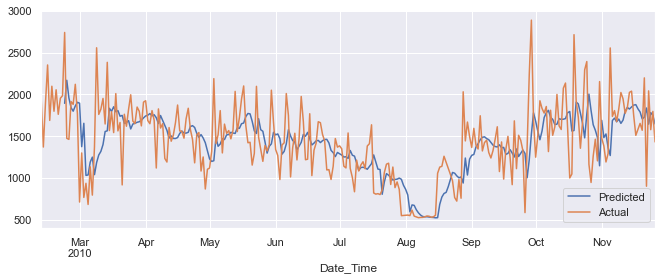

In [51]:
pred_s = pd.Series(np.squeeze(preds.numpy()))
pred_s.index = test_X.index[11:]
pred_s.plot(label="Predicted")
test_X.plot(label="Actual")
plt.legend()
plt.savefig("nn-plot")